In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import numpy as np

import matplotlib.pyplot as plt

import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')

cpu


# Simulation Config


In [29]:
# Spatial Domain
xmin, xmax = -2*np.pi, 2*np.pi  # Domain limits
Nx = 512                        # Number of Spatial points
L = abs(xmax - xmin)            # Domain Length
dx = L / (Nx - 1)               # Cell width

x = np.linspace(xmin, xmax, Nx)
x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)


# Temporal Domain
Tf = 2.0                # Final time
dt = 0.01               # Time step
Nt = int(Tf / dt) + 1   # Number of temporal points

t = np.linspace(0, Tf, Nt)
t_tensor = torch.tensor(t, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)

In [30]:
print(f'x: {x_tensor}')

x: tensor([[-6.2832],
        [-6.2586],
        [-6.2340],
        [-6.2094],
        [-6.1848],
        [-6.1602],
        [-6.1356],
        [-6.1110],
        [-6.0865],
        [-6.0619],
        [-6.0373],
        [-6.0127],
        [-5.9881],
        [-5.9635],
        [-5.9389],
        [-5.9143],
        [-5.8897],
        [-5.8651],
        [-5.8405],
        [-5.8159],
        [-5.7914],
        [-5.7668],
        [-5.7422],
        [-5.7176],
        [-5.6930],
        [-5.6684],
        [-5.6438],
        [-5.6192],
        [-5.5946],
        [-5.5700],
        [-5.5454],
        [-5.5208],
        [-5.4963],
        [-5.4717],
        [-5.4471],
        [-5.4225],
        [-5.3979],
        [-5.3733],
        [-5.3487],
        [-5.3241],
        [-5.2995],
        [-5.2749],
        [-5.2503],
        [-5.2257],
        [-5.2011],
        [-5.1766],
        [-5.1520],
        [-5.1274],
        [-5.1028],
        [-5.0782],
        [-5.0536],
        [-5.0290],
        [

In [31]:
print(f't: {t_tensor}')

t: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900],
        [0.1000],
        [0.1100],
        [0.1200],
        [0.1300],
        [0.1400],
        [0.1500],
        [0.1600],
        [0.1700],
        [0.1800],
        [0.1900],
        [0.2000],
        [0.2100],
        [0.2200],
        [0.2300],
        [0.2400],
        [0.2500],
        [0.2600],
        [0.2700],
        [0.2800],
        [0.2900],
        [0.3000],
        [0.3100],
        [0.3200],
        [0.3300],
        [0.3400],
        [0.3500],
        [0.3600],
        [0.3700],
        [0.3800],
        [0.3900],
        [0.4000],
        [0.4100],
        [0.4200],
        [0.4300],
        [0.4400],
        [0.4500],
        [0.4600],
        [0.4700],
        [0.4800],
        [0.4900],
        [0.5000],
        [0.5100],
        [0.5200],
        [0.5300],
        [0.5400],
       

# PDE Setup

In [32]:
def initialise(x_tensor, condition):
    """
    Initialize the solution based on different initial conditions.
    
    Args:
    - x_tensor: Tensor of Nx spatial points.
    - condition: Integer representing the type of initial condition to use.
    
    Returns:
    - u_0: Initial condition evaluated at the spatial points x.
    """
    Nx = x_tensor.shape[0]
    u_0 = torch.zeros(Nx, dtype=torch.float32, requires_grad=True).to(device)

    if condition == 1:
        # Singular initial data
        print("Initial Condition: 1/4 * ((x_j >= 3*pi/4) && (x_j <= 5*pi/4)) + 1/2 * ((x_j >= pi/2) && (x_j <= 3*pi/2)")
        for j in range(Nx):
            u_0[j] = (0.25 * ((x_tensor[j] >= 3*np.pi/4) & (x_tensor[j] <= 5*np.pi/4))) + \
                           (0.5 * ((x_tensor[j] >= np.pi/2) & (x_tensor[j] <= 3*np.pi/2)))

    elif condition == 2:
        # Polynomial initial data
        print("Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.")
        for j in range(Nx):
            if (x_tensor[j] >= np.pi/2) and (x_tensor[j] < 3*np.pi/2):
                u_0[j] = (6/np.pi**3) * (3*np.pi/2 - x_tensor[j]) * (x_tensor[j] - np.pi/2)
            else:
                u_0[j] = 0

    elif condition == 3:
        # Sine initial data
        print("Initial Condition: sin(x)")
        u_0 = torch.sin(x_tensor)

    return u_0


# def flux(V_U, u, x_index):
#     return -K*V_U[x_index] * u[x_index]

def flux(u):
    return 0.5*u*u


# Initial data
u_0 = initialise(x_tensor, 3)

Initial Condition: sin(x)


Text(0, 0.5, 'u(x, 0)')

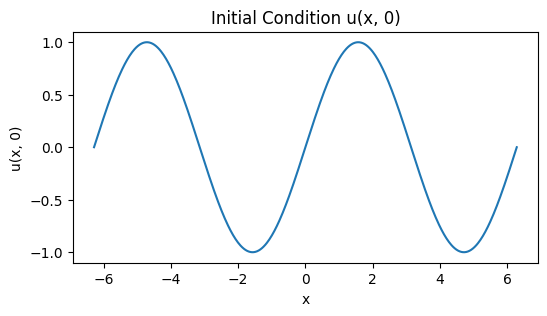

In [33]:
plt.figure(figsize=(6, 3), dpi=100)
plt.plot(x, u_0.squeeze().detach().cpu().numpy(), label='Initial Condition')
plt.title('Initial Condition u(x, 0)')
plt.xlabel('x')
plt.ylabel('u(x, 0)')

# Helper

In [34]:
def plot():
    """
    Plot the sim_data from the PINN model and the exact solution.
    
    Args:
    - sim_data: Predicted values for each time step (2D array: time x space).
    - ex_data: Optional exact solution data (same shape as sim_data).
    """
    sim_data = np.loadtxt('simulation_data.txt')
    
    ex_data_exists = os.path.getsize("uex.txt") > 0
    if ex_data_exists:
        ex_data = np.loadtxt('uex.txt')

    x = np.linspace(xmin, xmax, Nx)
    
    time_steps = len(sim_data)
    Dt = Tf / (time_steps-1)
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\mu(\theta)$')

    for _, t in enumerate([10,20,40,80,160,200]):
        plt.clf()
        plt.title(f'PINN Simulation after Time Step {t}, t={round(t*Dt, 3)}')

        # Exact Solution
        if ex_data_exists:
            plt.plot(x, ex_data[t, :], linestyle=":", marker="o", markersize=1, markerfacecolor='none', label='Exact Solution')
        # PINN Solution
        plt.plot(x, sim_data[t, :], linestyle=":", marker="x", markersize=3, label='PINN Prediction')
        
        plt.savefig('steps/f{t}.png', bbox_inches='tight')
        # plt.legend()
        # plt.draw()
        # plt.pause(0.08)

    # plt.show()


def write_data(filename, u):
    """
    Write the simulation results to a file.
    
    Args:
    - filename: The file object to write to.
    - u: The array of predicted values (1D array for a single time step).
    """
    with open(filename, 'w') as file:
        for step in range(u.shape[0]):
            file.write(" ".join(map(str, u[step, :])) + "\n")


def get_param():
    """
    Print the simulation parameters relevant to the PINN model.
    """
    print("\nPINN Simulation Parameters\n")
    print(f"Domain Limits (xmin, xmax): {xmin} , {xmax}")
    print(f"Domain Length (L): {L}")
    print(f"Number of Spatial Points (Nx): {Nx}")
    print(f"Cell Width (dx): {dx}\n")
    print(f"Final Time (Tf): {Tf}\n")
    print(f"Time Step (dt): {dt}")
    print(f"Number of Time Steps (Nt): {Nt}\n")


# Network Architecture
### Simple FeedForward Neural Network

-> 1 input layer

-> 4 fully connected hidden layers; 64 neurons each

-> 1 output layer

In [35]:
class PINN(nn.Module):
    def __init__(self, layers, units):
        """
        Initialise the PINN model.
        
        Args:
        - layers: number of hidden layers
        - units: number of neurons in each hidden layer 
        """
        super(PINN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, units)) # input layer ~> {x, t}
        for _ in range(layers): 
            self.layers.append(nn.Linear(units, units)) # hidden layers
        self.layers.append(nn.Linear(units, 1)) # output layer ~> u(x, t)
        

    def forward(self, t, x):
        """
        Forward pass through the network. It takes in time `t` and space `x` and outputs the solution `u(t, x)`.
        
        Args:
        - t: Time step.
        - x: Tensor of N space values
        
        Returns:
        - u: Neural network output representing the function `u(t, x)`.
        """
        input_data = torch.cat([t.repeat(x.shape[0], 1), x], dim=1)
        for _, layer in enumerate(self.layers[:-1]):
            input_data = torch.tanh(layer(input_data))      # tanh activation
        output = self.layers[-1](input_data)
        
        return output


    def pde_residual(self, t, x):
        """
        Compute the residual of the PDE: u_t + f(u)_x = 0
        f(u) = -k*V(u_x)*u_x
        
        Args:
        - t: Time step.
        - x: Tensor of N space values.
        
        Returns:
        - residual: The residual of the PDE at the given points (t, x).
        """
        u = self.forward(t, x)
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        uu_x = torch.autograd.grad(flux(u), x, grad_outputs=torch.ones_like(u), create_graph=True)[0].sum()
        # u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        k = -1

        # residual = u_t + -k*V(u_x)*u_x
        residual = u_t + uu_x
        return residual


    def loss(self, t_tensor, x, u_0):
        """
        Compute the total loss function including PDE residuals, initial, and boundary conditions.
        
        Args:
        - time_tensor: Tensor of nt temporal values.
        - x: Tensor of N space values.
        - u_0: Tensor of initial condition values for u(x, t0).
        - x_min: Tensor representing the minimum boundary in space.
        - x_max: Tensor representing the maximum boundary in space.
        
        Returns:
        - total_loss: The total loss combining PDE residuals, initial condition loss, and boundary loss.
        """
        total_loss = 0
        for time_step in t_tensor:
            # PDE residual loss
            total_loss += self.pde_residual(time_step, x)**2

            # Initial condition loss
            u_0_pred = self.forward(torch.as_tensor(0.0, device=x.device), x)
            total_loss += torch.mean((u_0_pred - u_0)**2)

            # Boundary condition loss
            u_pred = self.forward(time_step, x)
            total_loss += (u_pred[1] - u_pred[-1])**2
        
        return total_loss/Nt


    def train(self, t, x, u_0, x_min, x_max, epochs=512, lr=1e-4):
        """
        Train the PINN using the provided data and physics constraints.
        
        Args:
        - t: Time step.
        - x: Tensor of N space values.
        - u_0: Tensor of initial condition values for u(x, t0).
        - x_min: Tensor representing the minimum boundary in space.
        - x_max: Tensor representing the maximum boundary in space.
        - epochs: Number of training epochs.
        - lr: Learning rate for the optimizer.
        """
        # Adam optimizer and learning rate scheduler
        optimizer_adam = optim.Adam(self.parameters(), lr=lr)
        scheduler_adam = optim.lr_scheduler.StepLR(optimizer_adam, step_size=100, gamma=0.5)

        # LBFGS optimizer for later fine-tuning
        optimizer_lbfgs = optim.LBFGS(self.parameters(), max_iter=500)

        # Early stopping
        best_loss = float('inf')
        epochs_no_improve = 0
        patience = epochs/2
        
        lbfgs_epochs = 128
        adam_epochs = epochs - lbfgs_epochs
        
        loss_list = []
        
        print(f"Using Adam for {adam_epochs} epochs.")
        for epoch in range(epochs):
            if epoch < adam_epochs:  # Adam phase
                optimizer_adam.zero_grad()
                
                loss = self.loss(t, x, u_0)
                loss_list.append(loss.item())
                
                loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer_adam.step()
                scheduler_adam.step()

            else:  # LBFGS fine-tuning
                if epoch == adam_epochs+1:
                    print(f"\nUsing LBFGS for remaining {lbfgs_epochs} epochs.")

                def closure():
                    optimizer_lbfgs.zero_grad()
                    loss = self.loss(t, x, u_0)
                    loss.backward(retain_graph=True)
                    loss_list.append(loss.item())
                    return loss
                
                optimizer_lbfgs.step(closure)
                loss = self.loss(t, x, u_0)


            if loss.item() < best_loss:
                best_loss = loss.item()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}.")
                break
            

            if epoch % 32 == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')
        
        print("Training complete.")
        plt.semilogy(range(len(loss_list)), loss_list)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("Training Loss over Epochs")

model = PINN(layers=4, units=64).to(device)

# Training


In [36]:
model.train(t_tensor, x_tensor, u_0, xmin, xmax, epochs=512, lr=1e-4)
summary(model)

Using Adam for 384 epochs.
Epoch 0/512, Loss: 27.493694305419922
Epoch 32/512, Loss: 0.5708388686180115
Epoch 64/512, Loss: 0.5443896055221558
Epoch 96/512, Loss: 0.5101837515830994
Epoch 128/512, Loss: 0.5058146715164185


# Prediction

In [ ]:
get_param()
for time_step in t_tensor:
    u_n = model(time_step, x_tensor)
    write_data("simulation_data.txt", u_n.squeeze().detach().cpu().numpy())
plot()